# Time Series: This is my Design (Matrix)

## Extrema and Spectra

I tend to think of things in black and white. Considering this is a data science blog, I guess I could say that I prefer binary concepts. And why shouldn't it? It's easier that way! But unfortunately, pretty much nothing falls into this paradigm. Nevertheless, I often find myself asking is "Were does _this_ end and _that_ begin?" (_think of a funny one here_) I can think of two, separate concepts in isolation, but it's often hard to marry them.

When I first started to learn about machine learning, specifically supervised learning, I felt comfortable with taking some input `X`, and determining a function `f(X)` that best maps `X` to some known output value `y`. Separately, I dove a little into time series analysis and thought of this as a completely different paradigm. We don't think of things in terms of features or inputs; rather, we have the time series `y`, and `y` alone, and we look at previous values of `y` to predict future values of `y`.

Still, I often wondered, "Where does machine learning end and time series begin?". Or, "How do I use "features" in time series?". I guess if you can answer these questions really well, then you're in for making some money in finance. Or not. I have no idea - I really know nothing about that world.

I have had trouble answering these questions, in no small part due to the common difficulty of dealing with domain-specific vocabulary. I find myself having to internally translate time series concepts into "familiar" machine learning concepts. With this in mind, I would thus like to kick off a series of blog posts around analyzing time series data with the hopes of presenting these concepts in a familiar form.

To start the series off, in this post I'll introduce a time series dataset that I've gathered. I'll then walk through how we can turn the time series forecasting problem into a classic linear regression problem. 


## You gotta Data before you can Analyze

The requirements for a suitable time series dataset are fairly minimal: We need some quantity that changes with time. Ideally, our data set could exhibit some patterns such that we can learn some things like seasonality and cyclic behavior. Thankfully, I've got just the dataset!

This is where you groan because I say that the dataset is related to the Citi Bike NYC bikeshare data. _Everybody_ writes about this damn dataset, and it's been beaten to death. Well, I agree, but hear me out. I'm not using the _same_ dataset that everybody else uses. The typical Citi Bike dataset consists of all trips taken on the bikes. My dataset looks at the the number of bikes at each station as a function of time.

I started collecting this data about a year and a half ago because I was dealing with a common, frustrating scenario. I would check the Citi Bike app to make sure that there would be docks available at the station by my office before I left my apartment in the morning. However, by the time I rode to the office station, all the docks would have filled up, and I'd then have to go searching for a different station at which to dock the bike. Ideally, my app should tell me that, even though there are 5 docks available right now, they will likely be unavailable by the time I get there.

I wanted to collect this data and predict this myself. I still haven't done that, but hopefully we will later on in this blog series. In the meantime, since 9/18/2016, I pinged the Citi Bike API every 2 minutes to collect how many bikes and docks are available at every single citi bike station in NYC. This resulted in 123,584,800 records. In the spirit of not planning ahead, this all just runs on a cron job on a t2.micro EC2 instance backed by a Postgres database that is running locally on that instance. The code for this lives in [this](https://github.com/EthanRosenthal/bike-listener) repo, and somehow it's still running!

For more information about this dataset, I wrote a brief post on [Making Dia](https://making.dia.com/reducing-new-office-anxiety-with-a-new-citi-bike-dataset-fb469fd6f5b6).

For our purposes today, I am going to focus on a single time series from this data. The time series consists of the number of available bikes at the station at East 16th St and 5th Ave (i.e. the closest one to my apartment) as a function of time. Specifically, time is indexed by the `last_communication_time`. The Citi Bike API seems to update its values with random periodicity for different stations. The `last_communication_time` corresponds to the last time that the Citi Bike API talked to the station at the time of me querying.

We'll start by reading the data in with pandas. Pandas is probably the preferred library to use for exploring time series data in Python. It was originally built for analyzing financial data which is why it shines so well for time series. For an excellent resource on time series modeling in pandas, check out Tom Aguspurger's [post](https://tomaugspurger.github.io/modern-7-timeseries) in his Modern Pandas series. While I found that post to be extremely helpful, I am more interested in _why_ one does certain things with time series as opposed to _how_ to do these things.

My bike availability time series is in the form of a pandas `Series` object and is stored as a pickle file. Often, one does not care about the order of the index in Pandas objects, but, for time series, you will want to sort the values in chronological order. Note that I make sure the index is a sorted pandas `DatetimeIndex`.

In [3]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.ion()

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['figure.figsize'] = (8, 4)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 14

In [32]:
# Load and sort the dataframe.

df = pd.read_pickle('home_dat_20160918_20170604.pkl')
df.set_index('last_communication_time', inplace=True)
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)
df.head()

,execution_time,available_bikes,available_docks,id,lat,lon,st_address,station_name,status_key,status_value,test_station,total_docks
last_communication_time,,,,,,,,,,,,
2016-09-18 16:58:36,2016-09-18 16:59:51,4,43,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 16:58:36,2016-09-18 17:01:47,4,43,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:02:29,2016-09-18 17:03:42,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:02:29,2016-09-18 17:05:48,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47
2016-09-18 17:07:06,2016-09-18 17:07:44,7,40,496,40.737262,-73.99239,E 16 St & 5 Ave,E 16 St & 5 Ave,1,In Service,f,47


In [31]:
# Pick out our time series object
# and fix it to a 5-min sampling period

y = df.available_bikes
y.index.name = 'time'
y = y.resample('5T').last()
y.head()

time
2016-09-18 16:55:00     4.0
2016-09-18 17:00:00     7.0
2016-09-18 17:05:00     6.0
2016-09-18 17:10:00     5.0
2016-09-18 17:15:00    10.0
Freq: 5T, Name: available_bikes, dtype: float64

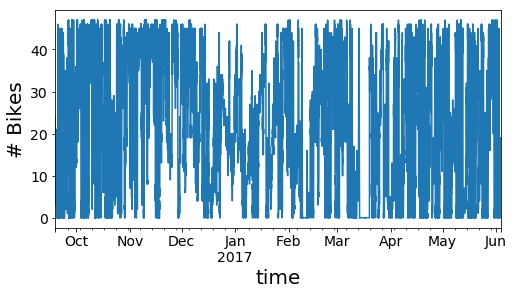

In [22]:
y.plot();
plt.ylabel('# Bikes');

As you can see, our time series looks like kind of a mess. We can zoom in on the first half of May to get a better view of what's going on. It looks like we have a regular rise and fall of our available bikes that happens each day with somewhat different behavior on the weekends (5/1 was a Monday, and 5/6 was a Saturday, in case you're wondering).

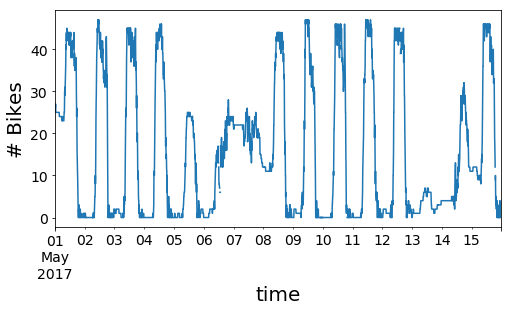

In [23]:
y.loc['2017-05-01':'2017-05-15'].plot();
plt.ylabel('# Bikes');

If we zoom in on a single day, we see that the number of bikes at the station rises in the morning, around 9 AM, and then plummets in the evening, around 6 PM. I'd call this a "commuter" station. There are a lot of offices around this station, so many people ride to the station in the morning, drop a bike off, and then pick up a bike in the evening and ride away. This works out perfectly for me, for it's like I have a reverse commute.

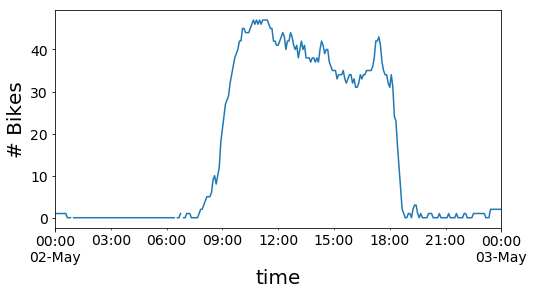

In [24]:
y.loc['2017-05-02 00:00:00':'2017-05-03 00:00:00'].plot();
plt.ylabel('# Bikes');

# <> Input <> Output <> Input <> Output <>

Ok! We have our time series. What now? Let's think about what we actually want to do with it. To keep things simple, let's say that we want to be able to predict the next value in the time series. As an example, if it was noon (i.e. 12:00 PM) on May 2nd, we would be trying to predict the number of bikes available at 12:05 PM, since our time series is in periods of 5 minutes.

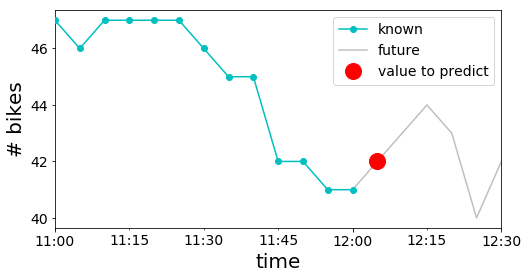

In [33]:
known = y.loc['2017-05-02 11:00:00':'2017-05-02 12:00:00']
unknown = y.loc['2017-05-02 12:00:00':'2017-05-02 12:30:00']
to_predict = y.loc['2017-05-02 12:05:00':'2017-05-02 12:06:00']

fig, ax = plt.subplots();
known.plot(ax=ax, c='c', marker='o', zorder=3);
unknown.plot(ax=ax, c='grey', alpha=0.5);
to_predict.plot(ax=ax, c='r', marker='o', markersize=16,
                linestyle='');

ax.legend(['known', 'future', 'value to predict']);
ax.set_ylabel('# bikes');

Now that we have framed our problem in terms of what we _know_ and what we want to predict, we walk back from whence we came towards ol' machine learning. In time series, instead of creating a bunch of features to input into our model, we instead use the historical, known values of our time series as "features" to input into a model. The future value of the time series that we want to predict is then our target label. Mathematically, we will think of $\textbf{X}$ as our "feature matrix" or "design matrix" from machine learning. We would like to approximate $y$ with $\hat{y}$, and we'll learn a function $\hat{y} = f(\textbf{X})$ in order to do this. Our $\textbf{X}$ matrix consists of previous values of $y$, our time series. Thus, at some point in time $t$,

$$\mathbf{X}_{t} = \mathbf{y}_{t^{\prime}<t}$$

where I have somewhat abused notation via the following

$$\mathbf{y}_{t^{\prime}<t} \equiv \big(y_{1}, y_{2}, ..., y_{t-2}, y_{t-1} \big)$$

where the portion on the right denotes a vector. Consequently, if we want to predict $y$ at time $t$, then it will be

$$\hat{y}_{t} = f(\mathbf{X}_{t})$$
$$\hat{y}_{t} = f(\mathbf{y}_{t^{\prime}<t-1})$$

Note that we cannot use future values to also predict the future. This is why we have to use the $t-1$ value of $\textbf{X}$ to predict $y_{t}$. In our graph from above, $t$ is 12:05 PM, the time that we are trying to predict. $\textbf{X}_{t-1}$ is the "known" cyan curve, and $y_{t}$ is the "value to predict" red marker.

# Building up the dataset

Now that we're able to think of time series in the comfortable form of $\hat{y} = f(\mathbf{X})$, how do we build up the full design matrix $\textbf{X}$? We would like to think of things in the scikit-learn paradigm, where we want to fit a design matrix $\textbf{X}$ in which each column is a feature dimension and each row is a separate "sample" or "data point". In our case, each column of $\textbf{X}$ will map to a previous value of $y$. We then have to think of how to build multiple samples.

Before we build samples, though, let's introduce the concept of a _window_. Recall that $\mathbf{X}_{t} = \mathbf{y}_{t^{\prime}<t}$. We _could_ use all values of $y$ up until time $t$, but this would quickly get unwieldy for large time series. Instead, we can consider some finite number of $y$ values preceding $t$. This finite range is our window. For a window size $w$, $\mathbf{X}_{t} = \big(y_{t-w}, y_{t-w+1},..., y_{t-2}, y_{t-1} \big)$.

We can now build up our data samples. We will chop our time series into a bunch of samples where each $\mathbf{X}_{t}$ is a length $w$ vector, and our targets are $y_{t}$. We'll again do this graphically. We take a window size of 5, and create 8 data points near noon on May 2nd.

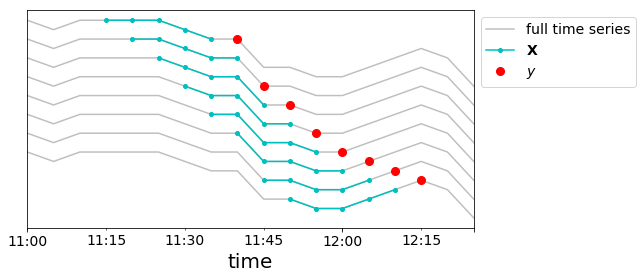

In [34]:
fig, ax = plt.subplots();

start = '2017-05-02 11:00:00'
start = np.where(y.index == start)[0][0]
middle = '2017-05-02 12:15:00'
middle = np.where(y.index == middle)[0][0]
end = '2017-05-02 12:30:00'
end = np.where(y.index == end)[0][0]

window = 5

for i in range(8):
    
    full = y.iloc[start:end]
    train = y.iloc[middle - i - window:middle - i ]
    predict = y.iloc[middle - i:middle - i + 1]   
    
    (full + 2*i).plot(ax=ax, c='grey', alpha=0.5);
    (train + 2*i).plot(ax=ax, c='c', markersize=4,
                       marker='o')
    (predict + 2*i).plot(ax=ax, c='r', markersize=8, 
                         marker='o', linestyle='')

    
ax.get_yaxis().set_ticks([]);
ax.legend(['full time series', 
           '$\mathbf{X}$', 
           '$y$'],
          bbox_to_anchor=(1, 1));

# [Just when I thought I was out, linear regression pulls me back in](https://www.youtube.com/watch?v=G29DXfcdhBg)

We are now capable of building up a dataset in an analogous format to how we conventionally think about machine learning problems. Let's say that we come up with some simple, linear model. We would like to learn some "feature weights" $\mathbf{a}$, such that

$$\mathbf{X}\mathbf{a} = \hat{\mathbf{y}}$$

Recall the shape of $\mathbf{X}$. We have a row for each data sample that we have created. For a time series of length $t$, and a window size of $w$, then we will have $t - w$ rows. The number of columns in $\textbf{X}$ is $w$. Consequently, $\textbf{a}$ will be a length-$w$ column vector. Putting it all together in matrix form looks like

$$
\begin{bmatrix}
    y_{1} & y_{2} & y_{3} & \dots  & y_{w} \\
    y_{2} & y_{3} & y_{4} & \dots  & y_{w + 1} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    y_{t - 2 - w} & y_{t - 1 - w} & y_{t - w} & \dots  & y_{t - 2} \\
    y_{t - 1 - w} & y_{t - w} & y_{t - w + 1} & \dots  & y_{t - 1} \\
\end{bmatrix}
\begin{bmatrix}
    a_{0} \\
    a_{1} \\
    \vdots \\
    a_{w-1} \\
    a_{w}
\end{bmatrix} 
=
\begin{bmatrix}
    \hat{y}_{w} \\
    \hat{y}_{w + 1} \\
    \vdots \\
    \hat{y}_{t - 1} \\
    \hat{y}_{t}
\end{bmatrix} 
$$

How could we learn these feature weights $\textbf{a}$? Ordinary Linear Regression would work fine. This means that our loss function looks like

$$\frac{1}{t-w}\sum\limits_{i=w}^{i=t}\big(y_{i} - \hat{y}_{i}\big)^{2}$$

We're then free to minimize however we want. We'll use `scikit-learn` for convenience:

In [27]:
#Build our matrices

window = 5
num_samples = 8
X_mat = []
y_mat = []
for i in range(num_samples):
    X_mat.append(y.iloc[middle - i - window:middle - i].values)
    y_mat.append(y.iloc[middle - i:middle - i + 1].values)

X_mat = np.vstack(X_mat)
y_mat = np.concatenate(y_mat)

assert X_mat.shape == (num_samples, window)
assert len(y_mat) == num_samples

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression(fit_intercept=False)
lr = lr.fit(X_mat, y_mat)
y_pred = lr.predict(X_mat)

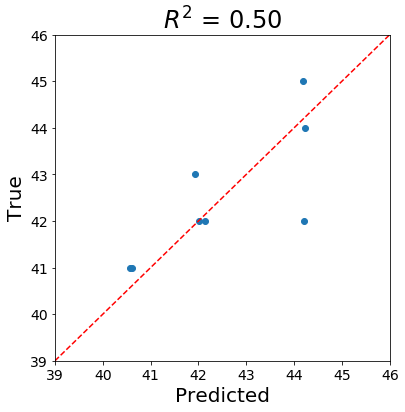

In [40]:
fig, ax = plt.subplots(figsize=(6, 6));

ax.scatter(y_pred, y_mat);

one_to_one = np.arange(y_mat.min()-2, y_mat.max()+2)
ax.plot(one_to_one, one_to_one, c='r', linestyle='--');

ax.set_xlim((one_to_one[0], one_to_one[-1]));
ax.set_ylim((one_to_one[0], one_to_one[-1]));
ax.set_xlabel('Predicted');
ax.set_ylabel('True');
ax.set_title(f'$R^{2}$ = {r2_score(y_mat, y_pred):3.2f}');

Now you can ask yourself if what we've done is okay, and the answer should probably be "No". I'm assuming most statisticians would be extremely uncomfortable right now. There's all sorts of issues, but first and foremost our data points are most assuredly not [IID](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). Most of the statiscial issues with the above roll up into the concept that the data must be _stationary_ before running a regression. 

However, I'm fine with what we did. The goal of the above was to show that it is _possible_ to cast a time series problem into a familiar format. In the next post, I'll show how we can do this _correctly_.

Now that we've seen how to turn a time series problem into a typical supervised learning problem, it should be fairly straightforward to see how we would add other features into this model. We would just add these features as extra columns in the design matrix, $\mathbf{X}$. The tricky part about time series is that, because you're predicting the future, you must know what the future values of your features will be. For example, we could add in a binary feature indicating whether or not there is rain into our bike availablility forecaster. While this could potentially be useful for increasing accuracy on the training data, we would need to be able to accurately forecast the weather in order to forecast the time series far into the future, and we all know how hard weather forecasting is!

# Statelessness: Dory-fying your time series

Ok! We have our time series. What now? Everywhere I looked would dive into talking about how one needs to now make their time series "stateless", and then they'd talk about subtracting means, differencing, and a bunch of other things. But, I struggled to find a definition of stateless, and, more importantly, why should the time series be stateless to begin with?



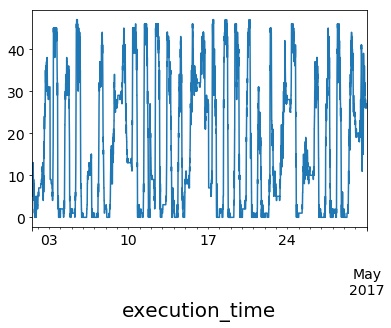

In [426]:
train = y.loc['2017-04-01 12:00:00':'2017-05-01 00:00:00']
train.plot();

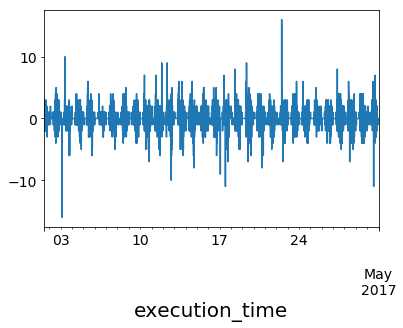

In [411]:
diff = train - train.shift(1)
# day = int(24 * 60 / 5)
# diff = diff - diff.shift(day)
# week = day * 7
# diff = diff - diff.shift(week)
diff.plot();

In [412]:
diff_X = ts_to_X(diff[~diff.isnull()], 5)

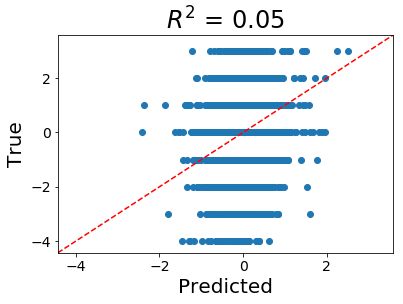

In [413]:
lr = LinearRegression(fit_intercept=False)
diff_y = diff[~diff.isnull()].values[5:]
lr = lr.fit(diff_X, diff_y)

y_pred = lr.predict(diff_X)
plt.scatter(y_pred, diff_y);
one_to_one = np.arange(y_pred.min()-2, y_pred.max()+2)
plt.plot(one_to_one, one_to_one, c='r', linestyle='--');
plt.xlim((one_to_one[0], one_to_one[-1]));
plt.ylim((one_to_one[0], one_to_one[-1]));
plt.xlabel('Predicted');
plt.ylabel('True');
plt.title(f'$R^{2}$ = {r2_score(diff_y, y_pred):3.2f}');

In [414]:
train.shape

(8497,)

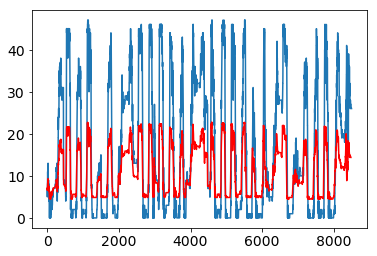

In [416]:
fig, ax = plt.subplots();
ax.plot(train[5:].values)
ax.plot(train[5] + y_pred.cumsum(), c='r');


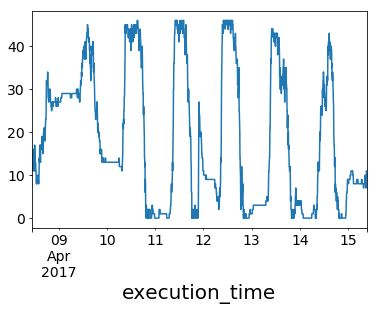

In [462]:
train[2000:4000].plot();

# Prophet stuff

In [519]:
from fbprophet import Prophet


In [587]:
train = y.loc['2017-03-01 12:00:00':'2017-05-01 00:00:00']
test = y.loc['2017-05-01 00:00:00':'2017-05-07 00:00:00']

In [579]:


def clean(df):
    df.interpolate(inplace=True)
    df = df.to_frame().reset_index()
    df.columns = ['ds', 'y']
    return df

train = clean(train)
test = clean(test)

m = Prophet()
m.fit(train);

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [580]:
future = m.make_future_dataframe(periods=500, freq='5T')
future.tail()

,ds
17920,2017-05-02 17:20:00
17921,2017-05-02 17:25:00
17922,2017-05-02 17:30:00
17923,2017-05-02 17:35:00
17924,2017-05-02 17:40:00


In [581]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
17920,2017-05-02 17:20:00,22.454504,10.367600,34.465075
17921,2017-05-02 17:25:00,22.030186,9.501688,34.885192
17922,2017-05-02 17:30:00,21.588326,9.278075,34.418075
17923,2017-05-02 17:35:00,21.130118,8.306272,34.312571
17924,2017-05-02 17:40:00,20.656855,8.184165,32.462416


In [582]:
test.head()

,ds,y
0,2017-05-01 00:00:00,26.0
1,2017-05-01 00:05:00,26.0
2,2017-05-01 00:10:00,26.0
3,2017-05-01 00:15:00,26.0
4,2017-05-01 00:20:00,26.0


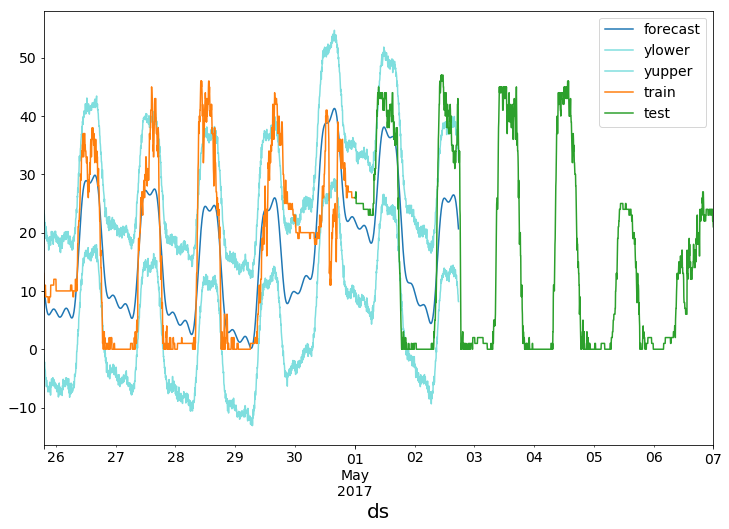

In [583]:
fig, ax = plt.subplots();
forecast[-2000:].set_index('ds').yhat.plot(ax=ax, label='forecast');
forecast[-2000:].set_index('ds').yhat_lower.plot(ax=ax, c='c', alpha=0.5, label='ylower');
forecast[-2000:].set_index('ds').yhat_upper.plot(ax=ax, c='c', alpha=0.5, label='yupper');
train[-1500:].set_index('ds').y.plot(ax=ax, label='train');

test.set_index('ds').y.plot(ax=ax, label='test');

ax.legend();

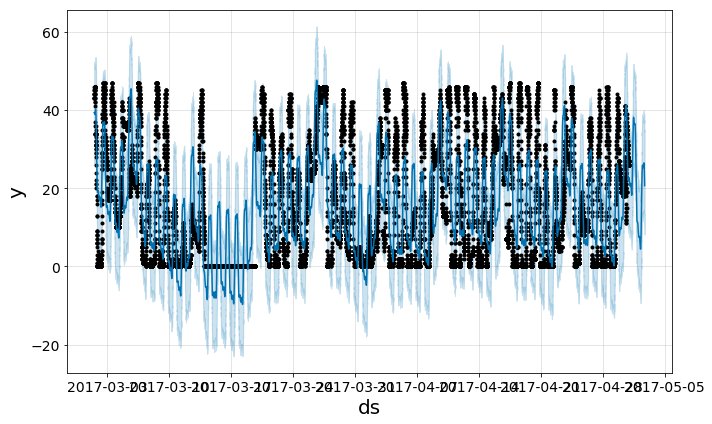

In [584]:
m.plot(forecast);

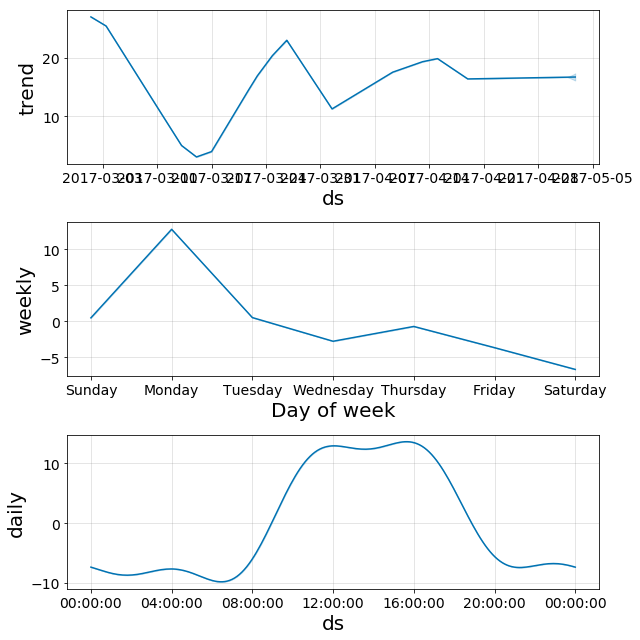

In [585]:
m.plot_components(forecast);


# Statsmodels stuff

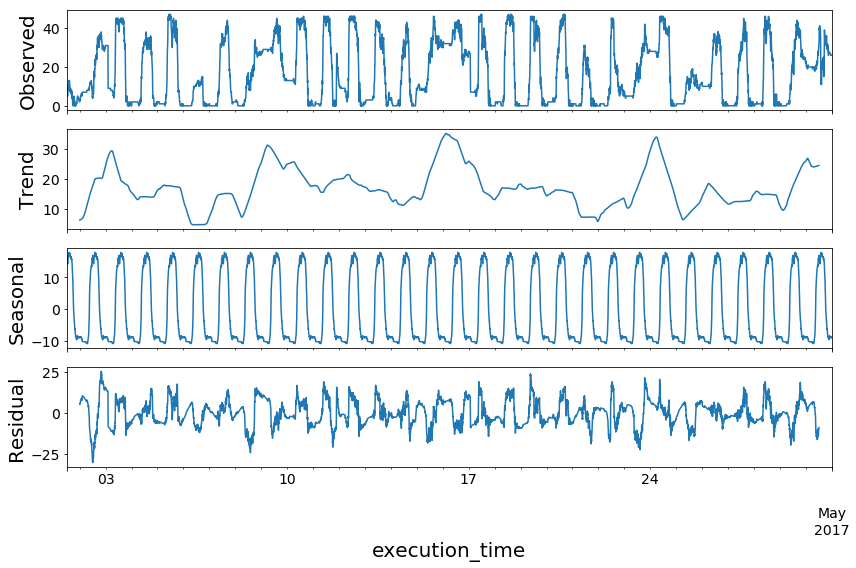

In [508]:
import statsmodels.api as sm

mpl.rcParams['figure.figsize'] = (12, 8)

tmp = train[:100000].copy()
tmp.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(tmp, freq=12*24)
resplot = res.plot()

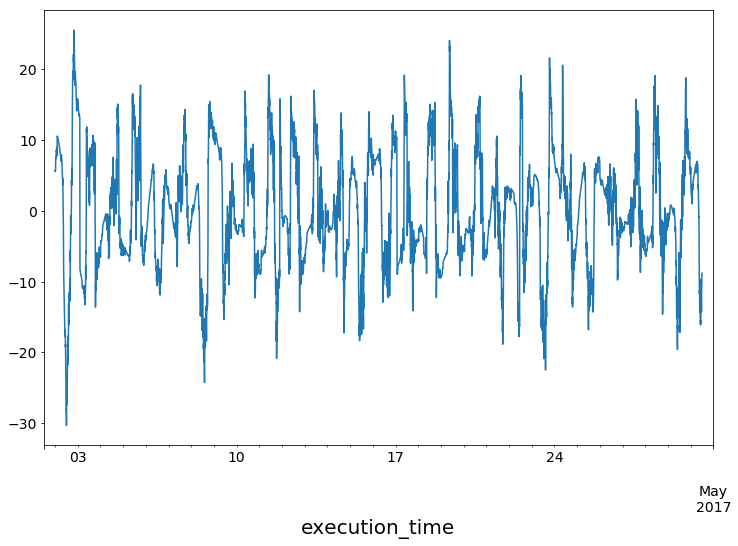

In [517]:
res.resid.plot()

# Random pyflux stuff

In [588]:
import pyflux as pf
tmp = pd.DataFrame(train)[:10000]
tmp.interpolate(inplace=True)
model = pf.ARIMA(data=tmp, ar=5, ma=5, target='available_bikes', family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMA(5,0,5)                                                                                       
======================================================= ==================================================
Dependent Variable: available_bikes                     Method: MLE                                       
Start Date: 2017-03-01 12:25:00                         Log Likelihood: -19397.9743                       
End Date: 2017-04-05 05:15:00                           AIC: 38819.9485                                   
Number of observations: 9995                            BIC: 38906.4666                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 13.6806    0.4149     32.9745  0.0      (12.8674 | 14.4938)      
AR(1)                                

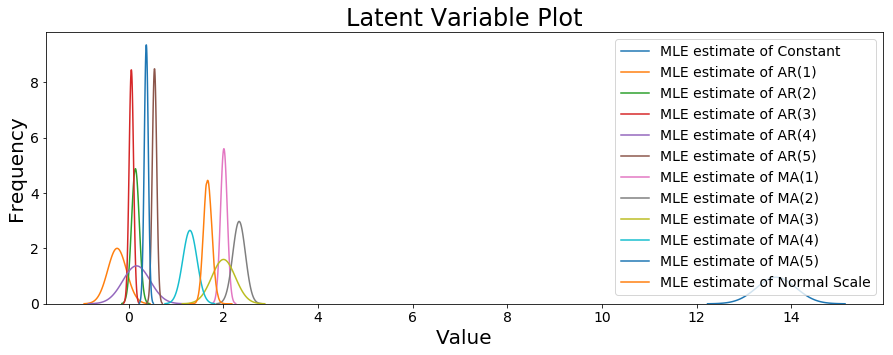

In [589]:
model.plot_z(figsize=(15,5))

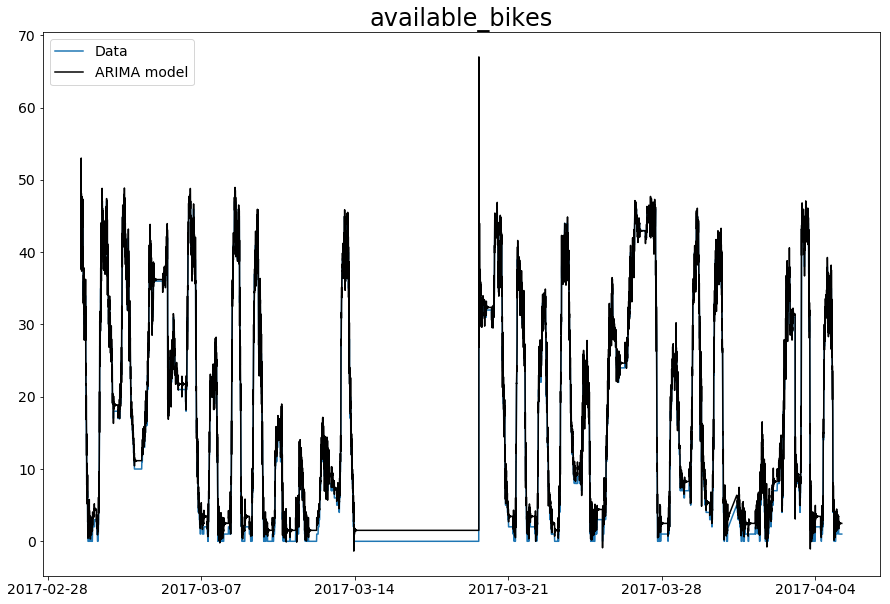

In [590]:
model.plot_fit(figsize=(15,10))

In [492]:
model.plot_predict??

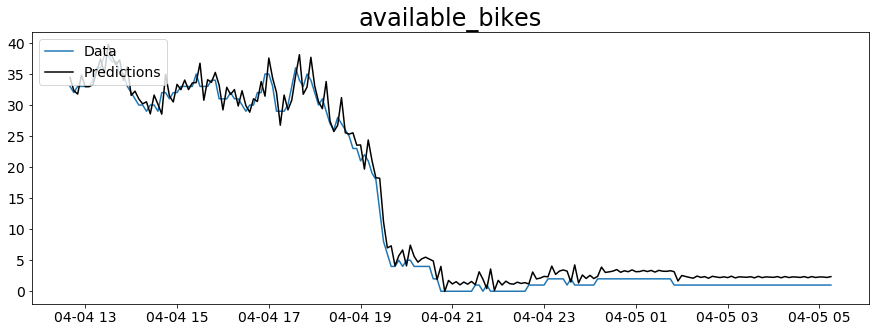

In [591]:
model.plot_predict_is(h=200, figsize=(15,5))

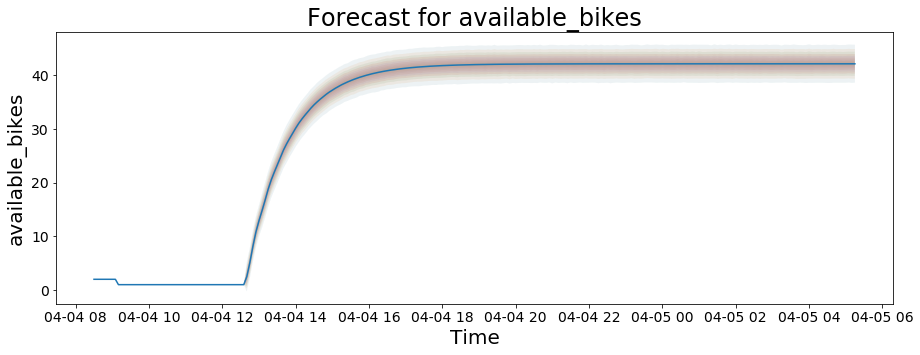

In [593]:
model.plot_predict(h=200,past_values=50,figsize=(15,5))

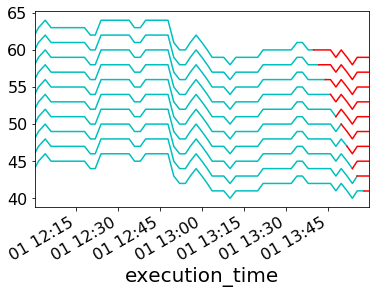

In [29]:
fig, ax = plt.subplots();
for i in range(1, 11):
    train = y.loc['2017-05-01 12:00:00':'2017-05-01 14:00:00'][:-i]
    (train + 2 * i).plot(ax=ax, c='c');
    test =  y.loc['2017-05-01 12:00:00':'2017-05-01 14:00:00'][-i-1:]
    (test + 2 * i).plot(ax=ax, c='r');
#     ax.set_ylabel('# Bikes');

# Outline

- Intro time series <> ML.
- Describe dataset
- Show how to turn time series into ML
- Carry out a basic autoregressive model.
- Maybe save differencing, trend, seasonality, etc... the next post.
- Each post ends with me trying to solve my problem:
  - Bike available in next 15 minutes.
  - Maybe we'll also add number of bikes tomorrow + 15 minutes.
- We'll do the basic autoregressive where we do everything wrong in the first post
- Do proper ARIMA and box-jenkins, in general
- VARIMAX, using other stations. Maybe combine this with 2.
- Something statespace. Is that the same as VARIMAX? Use pyflux
- Something bayesian with Prophet.
- LSTM because it's cool.
- That's a lot of posts
- Should do a simple classification at some point a la stockexchange?




Old outline

- No dask
- Plot a time seris (pandas). Point to Tom Augspurger.
- Discuss statelessness.
- Show some ways to make it (not important right now) and measure its statelessness.
- Talk about how to evaluate (e.g. that blog's version of last point validation)

Let's make the goal of all of these blog posts to talk about time series in the language of machine learning. For example, a model which just depends on the previous value and an average is like a bias and one single feature. Differencing and other things can be thought of as general "preprocessing" as scaling features or as applying feature transformations (e.g. polynomial transform).


In [281]:
np.repeat(np.arange(10)[np.newaxis, :], 5, axis=0) + np.arange(5)[:, np.newaxis]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [304]:
def ts_to_X(ts, window):
    num_rows = len(ts) - window
    indices = np.repeat(np.arange(window)[np.newaxis, :], 
                        num_rows, 
                        axis=0)
    indices += np.arange(num_rows)[:, np.newaxis]
    return ts[np.newaxis, :][:, indices].squeeze()


In [306]:
ts = np.random.random(size=20)
print(ts)
ts_to_X(ts, 2)

[ 0.78360851  0.63195677  0.09313087  0.92778908  0.06485323  0.81859897
  0.70093032  0.4365975   0.86350364  0.58688338  0.53797601  0.53270118
  0.30066766  0.41376958  0.01173914  0.25601081  0.44180202  0.73504036
  0.51988917  0.81852613]


array([[ 0.78360851,  0.63195677],
       [ 0.63195677,  0.09313087],
       [ 0.09313087,  0.92778908],
       [ 0.92778908,  0.06485323],
       [ 0.06485323,  0.81859897],
       [ 0.81859897,  0.70093032],
       [ 0.70093032,  0.4365975 ],
       [ 0.4365975 ,  0.86350364],
       [ 0.86350364,  0.58688338],
       [ 0.58688338,  0.53797601],
       [ 0.53797601,  0.53270118],
       [ 0.53270118,  0.30066766],
       [ 0.30066766,  0.41376958],
       [ 0.41376958,  0.01173914],
       [ 0.01173914,  0.25601081],
       [ 0.25601081,  0.44180202],
       [ 0.44180202,  0.73504036],
       [ 0.73504036,  0.51988917]])

In [295]:
np.broadcast(ts[np.newaxis, :], i)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [303]:
ts[np.newaxis, :][:, i].squeeze()

array([[ 0.29233826,  0.14161122,  0.33124115,  0.73438159,  0.92872565],
       [ 0.14161122,  0.33124115,  0.73438159,  0.92872565,  0.45356606],
       [ 0.33124115,  0.73438159,  0.92872565,  0.45356606,  0.31252277],
       [ 0.73438159,  0.92872565,  0.45356606,  0.31252277,  0.13373784],
       [ 0.92872565,  0.45356606,  0.31252277,  0.13373784,  0.82271289],
       [ 0.45356606,  0.31252277,  0.13373784,  0.82271289,  0.87104072],
       [ 0.31252277,  0.13373784,  0.82271289,  0.87104072,  0.25419243],
       [ 0.13373784,  0.82271289,  0.87104072,  0.25419243,  0.03121779],
       [ 0.82271289,  0.87104072,  0.25419243,  0.03121779,  0.90814966],
       [ 0.87104072,  0.25419243,  0.03121779,  0.90814966,  0.16252899],
       [ 0.25419243,  0.03121779,  0.90814966,  0.16252899,  0.85165889],
       [ 0.03121779,  0.90814966,  0.16252899,  0.85165889,  0.21811506],
       [ 0.90814966,  0.16252899,  0.85165889,  0.21811506,  0.15890386],
       [ 0.16252899,  0.85165889,  0.2

In [300]:
ts

array([ 0.29233826,  0.14161122,  0.33124115,  0.73438159,  0.92872565,
        0.45356606,  0.31252277,  0.13373784,  0.82271289,  0.87104072,
        0.25419243,  0.03121779,  0.90814966,  0.16252899,  0.85165889,
        0.21811506,  0.15890386,  0.83245674,  0.11420385,  0.09388662])